In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
from modules.utils import load_correspondences, visualize_correspondences
from modules.slam_pipeline import SlamPipeline
from modules.cheat import SlamPipelineCV

pipeline = SlamPipeline()
cheat = SlamPipelineCV()

## Visualize correspondances

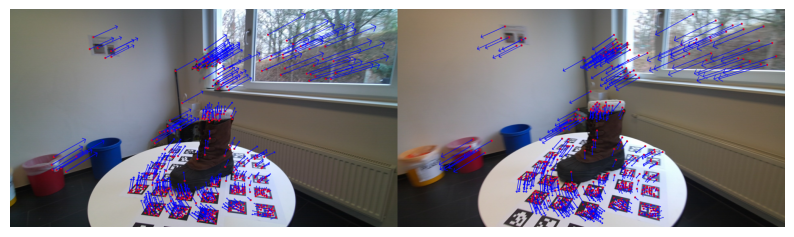

In [4]:
img1_path = "data/boot/images/00000.jpg"
img2_path = "data/boot/images/00002.jpg"
corr_path = './data/boot/correspondences/0_2.txt'
correspondences = load_correspondences(corr_path)
visualize_correspondences(img1_path, img2_path, correspondences)

## Fundamental matrix

In [11]:
correspondences = load_correspondences(corr_path)
F = pipeline.get_fund_mat(correspondences)
F_CV = cheat.get_fund_mat(correspondences)
print("Our F: ", F)
print("Ground truth F: ", F_CV)

Our F:  [[-4.62904604e-07 -1.01040008e-06  2.90772492e-03]
 [ 3.08559136e-06  1.58288617e-06 -1.22965154e-02]
 [-3.25928925e-03  9.30122101e-03  1.00000000e+00]]
Ground truth F:  [[-8.43912278e-07  4.03798884e-06 -4.55522707e-03]
 [-1.51703062e-06  2.32221977e-06  1.27549123e-02]
 [ 4.70293766e-03 -1.67550264e-02  1.00000000e+00]]


## Visualize RANSAC

In [10]:
values = []

error_values = np.arange(0.05, 3, 0.05)
for j in tqdm(error_values):
    for_mean = []
    for i in range(10):
        for_mean.append(pipeline.get_ransac_fund_mat(correspondences, 50, j)[1])
    values.append(np.array(for_mean).mean())

values = np.array(values) / len(correspondences)


100%|██████████| 59/59 [05:49<00:00,  5.93s/it]


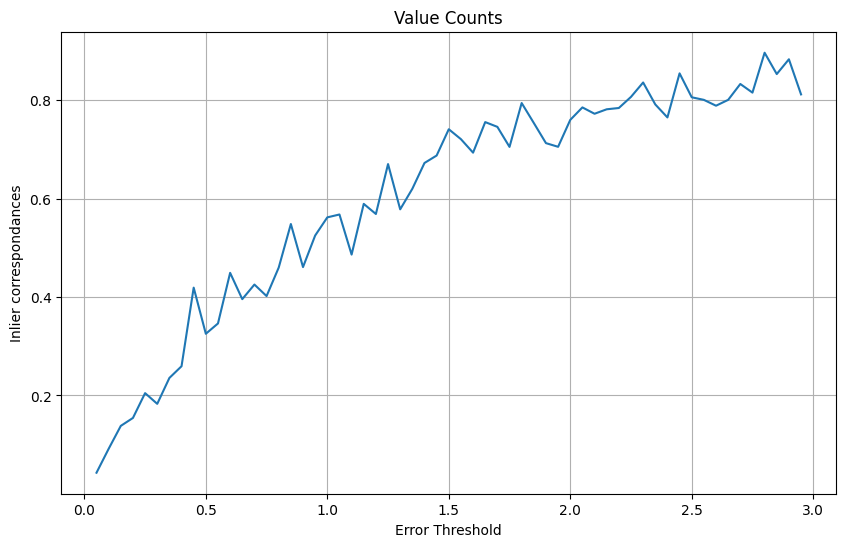

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(error_values,values, linestyle='-')
plt.title('Value Counts')
plt.xlabel('Error Threshold')
plt.ylabel('Inlier correspondances')
plt.grid(True)
plt.show()

## Essential Matrix

In [15]:
params_path = 'data/box/gt_camera_parameters.json'
E = pipeline.get_ess_mat(F_CV, params_path)
E_CV = cheat.get_ess_mat(correspondences)
print("Our E: ", E)
print("Ground truth E: ", E_CV)

Our E:  [[-0.06370993  0.30551982 -0.26072514]
 [-0.09698703  0.12327501  0.96133032]
 [ 0.2372646  -0.90876629  0.06091984]]
Ground truth E:  [[ 2.43760696e-05 -3.72817539e-04  2.66682188e-01]
 [ 2.97089212e-04  7.90720709e-06 -6.54889699e-01]
 [-2.58797052e-01  6.58045552e-01  4.03272240e-05]]


## Non linear optimization

In [55]:
import numpy as np
from scipy.optimize import least_squares

# X -> 3xnum_corr
# Ps -> 3x4 
# us -> 2xnum_corrr
def reprojection_error(X, Ps, corrs):
    X = X.reshape(corrs.shape[0], 3)
    X_homogeneous = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    error = np.array([])
    uv = corrs.T
    for P in Ps:
        u = uv[0]
        v = uv[1]
        u_pred = (P[0].reshape(1,-1) @ X_homogeneous.T) / (P[2].reshape(1,-1) @ X_homogeneous.T) 
        v_pred = (P[1].reshape(1,-1) @ X_homogeneous.T) / (P[2].reshape(1,-1) @ X_homogeneous.T)
        u_pred = u_pred.reshape(-1,1)[0]
        v_pred = v_pred.reshape(-1,1)[0]
        error = np.concatenate([error, (u - u_pred)**2, (v - v_pred)**2])
    return error

def refine_3d_points(X_initial, Ps, corrs):
    result = least_squares(reprojection_error, X_initial.flatten(), args=(Ps, corrs))
    return result.x.reshape(-1, 3)

# Given inputs
Ps = np.array([[[1, 2, 1, 1],
                [1, 1, 5, 1],
                [1, 3, 1, 2]],

               [[8, 1, 1, 3],
                [7, 1, 2, 1],
                [1, 2, 1, 1]]])

X_initial = np.array([[1, 2, 1],
                      [2, 1, 1],
                      [1, 3, 1],
                      [1, 1, 5],
                      [1, 1, 9]
                      ])

# Sample image coordinates
corrs = np.array([[1, 2],
               [3,1],
               [1, 2], 
               [3,4],
               [3,5]])

# Refine 3D points
refined_X = refine_3d_points(X_initial, Ps, corrs)
print("Refined 3D points:\n", refined_X)


Refined 3D points:
 [[1.77051235e+04 7.30794361e+03 4.95898008e+04]
 [2.00000000e+00 1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 3.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 5.00000000e+00]
 [1.00000000e+00 1.00000000e+00 9.00000000e+00]]
